In [1]:
import pysam as ps
from collections import defaultdict
import polars as pl
import matplotlib.pyplot as plt

In [2]:
# already subsetted bam by gene intervals, but more flexible to use the bamfile.fetch(interval) instead
tpmbam = ps.AlignmentFile("/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/tpm3.bam","rb")
mybam = ps.AlignmentFile("/users/mirimia/jchamberlin/scratch/data/IRIMIAMAN119/amphioxus/bambu_bla_fakegtf/mydgf.bam","rb")

In [3]:
# collect alignment intervals and subset to the TSS defined by paraclu:
temp_starts = []
temp_stops = []

for read in tpmbam.fetch():
    temp_starts.append(read.reference_start)
    temp_stops.append(read.reference_end)

boundary_df = pl.DataFrame({
    "tss": temp_stops,
    "pas": temp_starts
}).with_columns([
    (
        pl.when((pl.col("tss") >= 31030443) & (pl.col("tss") <= 31030578)).then(pl.lit("distal_tss"))
        # coordinates of strongest TSS peak ^^
        .when((pl.col("tss") >= 31024640) & (pl.col("tss") <= 31024712)).then(pl.lit("internal_tss"))
        # coordinates of secondary TSS peak ^^
        .otherwise(pl.lit("other")).alias("tss_category")
    )])



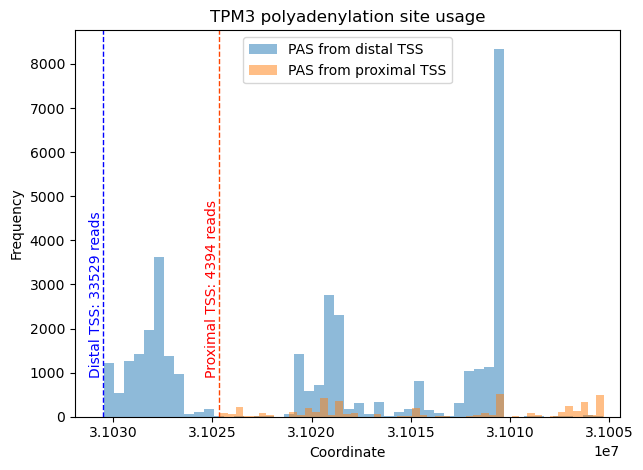

In [4]:
# restrict to the annotated gene interval omitting a few ultra-distal 'PAS' 
plot_df = boundary_df.filter((pl.col("pas") > 31004465) & (pl.col("pas") < 31031932))

for category in ["distal_tss","internal_tss"]:
    subset = plot_df.filter(pl.col("tss_category") == category)
    values = subset["pas"].to_list()
    plt.hist(values, bins=50, alpha=0.5, label=category)

plt.xlabel("Coordinate")
plt.ylabel("Frequency")
plt.title("TPM3 polyadenylation site usage")
plt.xlim(31004465, 31031932)
plt.tight_layout()
plt.axvline( (31024712+31024640) / 2, color = "#FF4500", linewidth = 1, linestyle='--') 
plt.axvline( (31030443+31030578) / 2, color = "blue", linewidth = 1, linestyle='--')
plt.gca().invert_xaxis()  # Flip the X-axis
plt.legend(labels = ["PAS from distal TSS","PAS from proximal TSS"])

plt.text((31024712+31024640) / 2, plt.ylim()[1]*0.1, 'Proximal TSS: 4394 reads', color='red', 
         rotation=90, verticalalignment='bottom', horizontalalignment='right')
plt.text((31030443+31030578) / 2, plt.ylim()[1]*0.1, 'Distal TSS: 33529 reads', color='blue',
         rotation=90, verticalalignment='bottom', horizontalalignment='right')

#plt.axvline((31010651+31010663)/2,color="gray",linestyle="-")
#plt.axvline((31005300+31005322)/2,color="gray",linestyle="-")
#plt.axvline(31010875,color="gray",linestyle="-")
#plt.axvline((31019275+31019324)/2,color="gray",linestyle="-")
#plt.axvline((31011369+ 31011381)/2,color="gray",linestyle="-")
#plt.axvline((31027822 +31027868)/2,color="gray",linestyle="-")

plt.show()

In [ ]:
# mydgf